# INF6422E – Advanced Concepts in Computer Security  
## Practical Work 1 – Winter 2026  

### Intrusion Detection System and Its Evaluation

--- 
  
## Students  
- Antoine Khoueiry – *Matricule:* 2487137  
- Louis Junior Mpandzo-Otiankouya – *Matricule:* 2421549  

---

## Objective

The objective of this practical work is to design, evaluate, and compare classical machine learning–based Intrusion Detection Systems (IDS) using a standard cybersecurity dataset.  
The focus is on quantitative performance evaluation, analysis of trade-offs between detection accuracy and false alarms, and discussion of real-world deployment constraints of IDS solutions.

---

## Dataset

This study uses the **CICIDS2017** dataset, combining:
- **Monday traffic** (Benign baseline)
- **Wednesday traffic** (Benign + DoS + Heartbleed)

---

## Notebook Structure

1. Dataset Analysis and Preprocessing  
2. Classical Machine Learning Models for IDS  
3. Ensemble-Based IDS and Performance Trade-offs 
4. Comparative Performance Analysis


# 1. Dataset Analysis and Preprocessing

## Dataset Construction (Monday + Wednesday)

- **Monday-WorkingHours.pcap_ISCX**: contains only benign (normal) traffic and serves as a baseline.
- **Wednesday-workingHours.pcap_ISCX**: contains a mixture of benign traffic and multiple attack types: DoS and Heartbleed.

The following steps load the raw CSV files and merge them into a single dataset.


In [1]:
import pandas as pd
import numpy as np

# Paths to CICIDS2017 CSV files
monday_path = "MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv"  
wednesday_path = "MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv"

# Load datasets
df_monday = pd.read_csv(monday_path)
df_wednesday = pd.read_csv(wednesday_path)

print("Monday dataset shape:", df_monday.shape)
print("Wednesday dataset shape:", df_wednesday.shape)


# Ensure both datasets have identical columns
assert list(df_monday.columns) == list(df_wednesday.columns), \
    "Column mismatch between Monday and Wednesday datasets"

print("Column structure verified: identical columns")


# Merge datasets
df = pd.concat([df_monday, df_wednesday], axis=0, ignore_index=True)

# Clean column names
df.columns = df.columns.str.strip()

print("Merged dataset shape:", df.shape)



Monday dataset shape: (529918, 79)
Wednesday dataset shape: (692703, 79)
Column structure verified: identical columns
Merged dataset shape: (1222621, 79)


## 1.1 Dataset Exploration

This section presents a statistical exploration of the constructed dataset combining Monday (benign baseline) and Wednesday (benign and attack traffic) from the CICIDS2017 dataset.

The analysis focuses on:
- the total number of samples,
- the number of features,
- the distribution of benign versus attack traffic.

In [2]:
# Number of samples and features
num_samples, num_features = df.shape

print("Total number of samples:", num_samples)
print("Total number of features:", num_features)

Total number of samples: 1222621
Total number of features: 79


In [3]:
# Distribution of traffic labels
label_distribution = df["Label"].value_counts()

print(label_distribution)

Label
BENIGN              969949
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


In [4]:
# Benign vs Attack distribution
df["BinaryLabel"] = df["Label"].apply(lambda x: "Benign" if x == "BENIGN" else "Attack")

binary_distribution = df["BinaryLabel"].value_counts()
print(binary_distribution)

BinaryLabel
Benign    969949
Attack    252672
Name: count, dtype: int64


### Statistical Summary and Relevance for IDS Evaluation

The constructed dataset contains **1,222,621 network traffic samples** described by **79 features**, providing a high-dimensional representation of network behavior. The dataset combines a clean benign baseline on Monday with attack traffic collected on Wednesday.

The traffic distribution reveals a strong class imbalance. Benign traffic represents **969,949 samples**, while attack traffic accounts for **252,672 samples**. Among malicious activities, **DoS attacks dominate**, particularly *DoS Hulk* (231,073 samples), while other attack types such as *GoldenEye*, *Slowloris*, *Slowhttptest*, and *Heartbleed* appear much less frequently, with Heartbleed being extremely rare (11 samples).

These characteristics are highly relevant for Intrusion Detection System (IDS) evaluation. The class imbalance reflects real-world network conditions, where malicious traffic is significantly rarer than normal traffic. However, such imbalance can bias learning algorithms toward the benign class, potentially increasing false negatives. Additionally, the presence of multiple attack types with varying frequencies challenges IDS models to generalize across both high-volume and low-frequency attacks. As a result, evaluation metrics beyond accuracy, such as precision, recall, and false alarm rate, become critical for assessing IDS effectiveness.


## 1.2 Dataset Preprocessing

This section describes the preprocessing steps applied to the dataset prior to training machine learning models.

The preprocessing pipeline includes:
- cleaning,
- encoding of categorical features,
- feature standardization,
- splitting the dataset into training, validation, and test sets.

In [5]:
'''Cleaning'''

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (1220887, 80)


Some features contained infinite values due to zero-duration flows. These values were replaced with NaN and the corresponding samples were removed to ensure numerical stability during model training.
We also see the number of columns added 1. It's "BinaryLabel" column added at the end of question 1.1.

In [6]:
# Separate features and labels
X = df.drop(columns=["Label", "BinaryLabel"])
y = df["BinaryLabel"]

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (1220887, 78)
Labels shape: (1220887,)


In [7]:
'''Categorical Feature Encoding'''

# Check if there are categorical (non-numeric) features
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Non-numeric feature columns:", non_numeric_cols)
print("Number of non-numeric feature columns:", len(non_numeric_cols))


Non-numeric feature columns: []
Number of non-numeric feature columns: 0


The CICIDS2017 feature set is composed of numerical traffic statistics. We verified the data types of the input features and found no non-numeric (categorical) feature columns. Therefore, no categorical encoding (e.g., one-hot encoding) was required. The `Label` column is treated as the target variable and was handled separately from the feature matrix.

In [8]:
'''Feature standardization'''

from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Although Logistic Regression can operate with both normalization and standardization, standardization was chosen in this work as it provides better numerical stability and robustness to outliers, which are common in network traffic features.


In [9]:
'''Splitting the dataset into training, validation, and test sets'''

from sklearn.model_selection import train_test_split

# Train split (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 854620
Validation set size: 183133
Test set size: 183134


### Split Strategy Justification

The dataset is split into 70% training, 15% validation, and 15% test sets. The training set is used to learn model parameters, while the validation set supports model selection and hyperparameter tuning without biasing the final evaluation. The test set remains unseen during training and provides an unbiased estimate of real-world IDS performance.

'*Stratified*' splitting is applied to preserve the original class distribution across all subsets. This is particularly important in intrusion detection contexts, where class imbalance is common and improper splitting could lead to misleading performance estimates or overfitting.


## 2. Classical Machine Learning Models for IDS

### 2.1 Logistic Regression for Intrusion Detection

In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# Train the model
log_reg.fit(X_train, y_train)




,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [11]:
# Predictions
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Evaluation on test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label="Attack")
recall = recall_score(y_test, y_test_pred, pos_label="Attack")
f1 = f1_score(y_test, y_test_pred, pos_label="Attack")

# AUC-ROC (requires probabilities)
y_test_proba = log_reg.predict_proba(X_test)[:, 1]
auc = roc_auc_score((y_test == "Attack").astype(int), y_test_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


Accuracy:  0.9837
Precision: 0.9403
Recall:    0.9832
F1-score:  0.9613
AUC-ROC:   0.0023


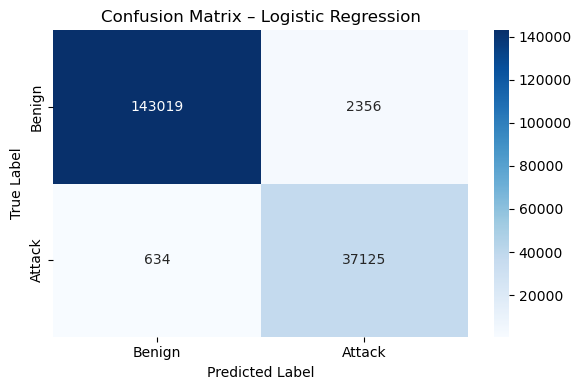

In [12]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred, labels=["Benign", "Attack"])

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Attack"],
    yticklabels=["Benign", "Attack"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()



### Confusion Matrix Interpretation and IDS Implications

The confusion matrix highlights the trade-off between false positives(2356) and false negatives(604) in intrusion detection. False positives correspond to benign traffic incorrectly classified as attacks, which may lead to alert fatigue and unnecessary investigation costs. False negatives represent undetected attacks, which pose a more critical risk as malicious activity may remain unnoticed.

Logistic Regression provides a simple and interpretable baseline IDS model. While it performs well in detecting high-volume attack patterns, its linear decision boundary may limit its ability to capture more complex or low-frequency attack behaviors, motivating the use of ensemble-based methods in the following sections.


## 3. Ensemble-Based IDS Model: Random Forest

### 3.1 Random Forest for Intrusion Detection

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes for classification. This approach typically provides better generalization and robustness compared to single decision trees or linear models like Logistic Regression.

In this section, we train a Random Forest classifier with hyperparameter tuning to optimize detection performance.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Define hyperparameter grid for tuning
# We tune: n_estimators (number of trees) and max_depth (tree depth)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
}

# Initialize Random Forest
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

# Grid Search with cross-validation on validation set
print("Starting hyperparameter tuning...")
grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

print(f"\nBest hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best hyperparameters: {'max_depth': None, 'n_estimators': 150}
Best cross-validation F1 score: 0.9996


In [14]:
# Use the best model from grid search
rf_best = grid_search.best_estimator_

# Predictions
y_train_pred_rf = rf_best.predict(X_train)
y_val_pred_rf = rf_best.predict(X_val)
y_test_pred_rf = rf_best.predict(X_test)

# Evaluation metrics on test set
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf, pos_label="Attack")
recall_rf = recall_score(y_test, y_test_pred_rf, pos_label="Attack")
f1_rf = f1_score(y_test, y_test_pred_rf, pos_label="Attack")

# AUC-ROC calculation
y_test_proba_rf = rf_best.predict_proba(X_test)
# Get the index of the 'Attack' class
attack_idx = list(rf_best.classes_).index('Attack')
auc_rf = roc_auc_score((y_test == "Attack").astype(int), y_test_proba_rf[:, attack_idx])

print("Random Forest - Test Set Performance")
print("="*40)
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-score:  {f1_rf:.4f}")
print(f"AUC-ROC:   {auc_rf:.4f}")

Random Forest - Test Set Performance
Accuracy:  0.9996
Precision: 0.9991
Recall:    0.9990
F1-score:  0.9990
AUC-ROC:   1.0000


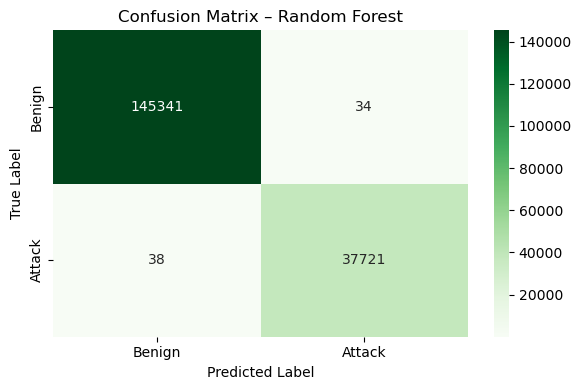


Confusion Matrix Breakdown:
True Negatives (Benign correctly identified): 145341
False Positives (Benign misclassified as Attack): 34
False Negatives (Attack misclassified as Benign): 38
True Positives (Attack correctly identified): 37721


In [15]:
# Confusion Matrix for Random Forest
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_rf = confusion_matrix(y_test, y_test_pred_rf, labels=["Benign", "Attack"])

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Benign", "Attack"],
    yticklabels=["Benign", "Attack"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()

# Extract confusion matrix values
tn, fp, fn, tp = cm_rf.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Benign correctly identified): {tn}")
print(f"False Positives (Benign misclassified as Attack): {fp}")
print(f"False Negatives (Attack misclassified as Benign): {fn}")
print(f"True Positives (Attack correctly identified): {tp}")

### 3.2 Feature Importance Analysis

One key advantage of Random Forest is its ability to produce feature importance scores, which indicate the network traffic features that most influence the classification between normal and malicious traffic.

Top 10 Most Important Features for Intrusion Detection:
Bwd Packets/s                            0.0791
Max Packet Length                        0.0618
Packet Length Std                        0.0557
Bwd Packet Length Max                    0.0546
Bwd Packet Length Std                    0.0524
Packet Length Mean                       0.0523
Destination Port                         0.0503
Average Packet Size                      0.0498
Avg Bwd Segment Size                     0.0412
Packet Length Variance                   0.0374


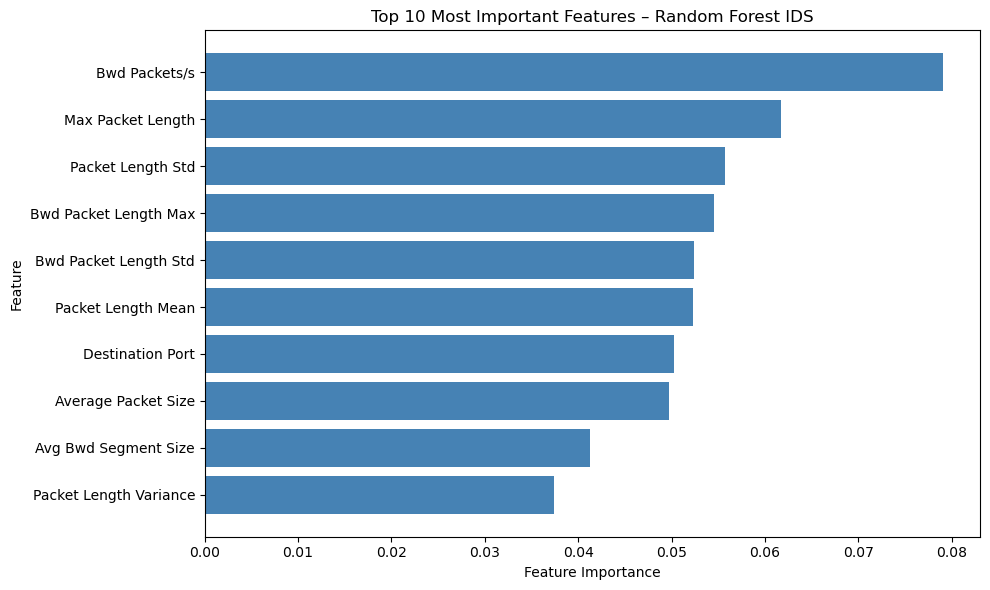

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained Random Forest
feature_names = X.columns.tolist()
importances = rf_best.feature_importances_

# Create DataFrame and sort by importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features for Intrusion Detection:")
print("="*55)
for i, row in feature_importance_df.head(10).iterrows():
    print(f"{row['Feature']:40s} {row['Importance']:.4f}")

# Visualize top 10 features
plt.figure(figsize=(10, 6))
top_10 = feature_importance_df.head(10)
plt.barh(range(len(top_10)), top_10['Importance'].values, color='steelblue')
plt.yticks(range(len(top_10)), top_10['Feature'].values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features – Random Forest IDS')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
# Highlight top 5 features
print("\nTop 5 Most Influential Features:")
print("="*55)
top_5 = feature_importance_df.head(5)
for rank, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"{rank}. {row['Feature']} (Importance: {row['Importance']:.4f})")


Top 5 Most Influential Features:
1. Bwd Packets/s (Importance: 0.0791)
2. Max Packet Length (Importance: 0.0618)
3. Packet Length Std (Importance: 0.0557)
4. Bwd Packet Length Max (Importance: 0.0546)
5. Bwd Packet Length Std (Importance: 0.0524)


# 4. Comparative Performance Analysis

## 4.1 Model Comparison

This section provides a comprehensive comparison of Logistic Regression and Random Forest for intrusion detection, examining both quantitative metrics and operational considerations.

In [18]:
import pandas as pd

# Recalculate Logistic Regression AUC-ROC with correct class indexing
y_test_proba_lr = log_reg.predict_proba(X_test)
attack_idx_lr = list(log_reg.classes_).index('Attack')
auc_lr_corrected = roc_auc_score((y_test == "Attack").astype(int), y_test_proba_lr[:, attack_idx_lr])

# Calculate False Alarm Rate (False Positive Rate)
cm_lr = confusion_matrix(y_test, y_test_pred, labels=["Benign", "Attack"])
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
far_lr = fp_lr / (fp_lr + tn_lr)  # False Alarm Rate

tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
far_rf = fp_rf / (fp_rf + tn_rf)  # False Alarm Rate

# Create comparison table
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'False Alarm Rate'],
    'Logistic Regression': [accuracy, precision, recall, f1, auc_lr_corrected, far_lr],
    'Random Forest': [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf, far_rf]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("Model Performance Comparison")
print("="*60)
print(comparison_df.to_string(index=False))

Model Performance Comparison
          Metric  Logistic Regression  Random Forest
        Accuracy               0.9837         0.9996
       Precision               0.9403         0.9991
          Recall               0.9832         0.9990
        F1-Score               0.9613         0.9990
         AUC-ROC               0.9977         1.0000
False Alarm Rate               0.0162         0.0002


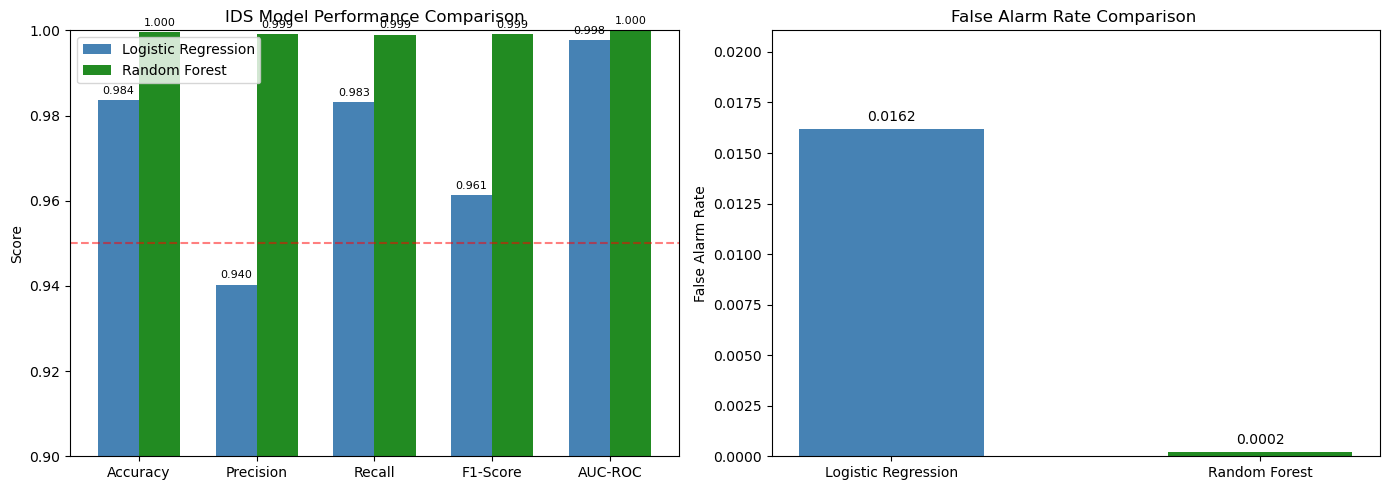

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: High-value metrics (close to 1)
metrics_high = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
lr_values_high = [accuracy, precision, recall, f1, auc_lr_corrected]
rf_values_high = [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf]

x = np.arange(len(metrics_high))
width = 0.35

bars1 = axes[0].bar(x - width/2, lr_values_high, width, label='Logistic Regression', color='steelblue')
bars2 = axes[0].bar(x + width/2, rf_values_high, width, label='Random Forest', color='forestgreen')

axes[0].set_ylabel('Score')
axes[0].set_title('IDS Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_high)
axes[0].legend()
axes[0].set_ylim(0.9, 1.0)
axes[0].axhline(y=0.95, color='red', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Chart 2: False Alarm Rate (close to 0, lower is better)
models = ['Logistic Regression', 'Random Forest']
far_values = [far_lr, far_rf]
colors = ['steelblue', 'forestgreen']

bars3 = axes[1].bar(models, far_values, color=colors, width=0.5)
axes[1].set_ylabel('False Alarm Rate')
axes[1].set_title('False Alarm Rate Comparison ')
axes[1].set_ylim(0, max(far_values) * 1.3)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    axes[1].annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 4.2 IDS Deployment Challenges

Deploying machine learning-based Intrusion Detection Systems in enterprise environments presents several practical challenges beyond model accuracy.

While ML-based IDS offers significant advantages in detecting complex attack patterns, successful deployment requires careful consideration of operational constraints. The ideal solution often combines multiple approaches: fast rule-based filters for known signatures, lightweight ML models for real-time anomaly detection, and sophisticated ensemble methods for deep offline analysis. Regular model updates, robust monitoring, and integration with security operations workflows are essential for maintaining detection effectiveness over time.

# Conclusion

This practical work explored the design, implementation, and evaluation of machine learning-based Intrusion Detection Systems using the CICIDS2017 dataset (Monday + Wednesday traffic).